In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

# Exploratory Data Analysis

Comprehensive analysis of retail datasets for demand forecasting.

**Analysis Sections:**
1. Data Loading & Overview
2. Univariate Analysis
3. Temporal Patterns
4. Category Analysis
5. Regional Analysis
6. Impact Analysis (Promotions, Weather, Discounts)
7. Correlation & Relationships
8. Advanced Time Series Analysis
9. Key Insights

## 1. Load Data

In [2]:
# Load datasets
with zipfile.ZipFile('data/1_data_A.zip', 'r') as z:
    with z.open('sales_data.csv') as f:
        df_a = pd.read_csv(f)

with zipfile.ZipFile('data/1_data_B.zip', 'r') as z:
    with z.open('product_sales_dataset_final.csv') as f:
        df_b = pd.read_csv(f)

# Parse dates
df_a['Date'] = pd.to_datetime(df_a['Date'])
df_b['Order_Date'] = pd.to_datetime(df_b['Order_Date'])

print(f'Dataset A: {df_a.shape[0]:,} × {df_a.shape[1]} | Period: {df_a["Date"].min().date()} to {df_a["Date"].max().date()}')
print(f'Dataset B: {df_b.shape[0]:,} × {df_b.shape[1]} | Period: {df_b["Order_Date"].min().date()} to {df_b["Order_Date"].max().date()}')

Dataset A: 76,000 × 16 | Period: 2022-01-01 to 2024-01-30
Dataset B: 200,000 × 14 | Period: 2023-01-01 to 2024-12-31


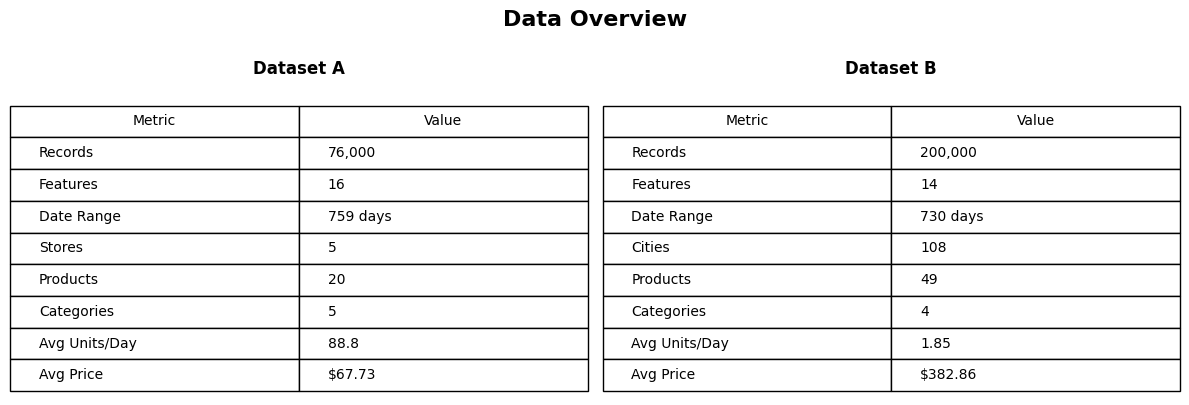

In [3]:
# Data overview grid
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Data Overview', fontsize=16, fontweight='bold', y=1.00)

# Dataset A - Info table
info_a = [
    ['Records', f'{len(df_a):,}'],
    ['Features', f'{df_a.shape[1]}'],
    ['Date Range', f'{(df_a["Date"].max() - df_a["Date"].min()).days} days'],
    ['Stores', f'{df_a["Store ID"].nunique()}'],
    ['Products', f'{df_a["Product ID"].nunique()}'],
    ['Categories', f'{df_a["Category"].nunique()}'],
    ['Avg Units/Day', f'{df_a["Units Sold"].mean():.1f}'],
    ['Avg Price', f'${df_a["Price"].mean():.2f}']
]
axes[0].axis('tight')
axes[0].axis('off')
table_a = axes[0].table(cellText=info_a, colLabels=['Metric', 'Value'], 
                          cellLoc='left', loc='center', colWidths=[0.5, 0.5])
table_a.auto_set_font_size(False)
table_a.set_fontsize(10)
table_a.scale(1, 2)
axes[0].set_title('Dataset A', fontweight='bold', fontsize=12, pad=20)

# Dataset B - Info table
info_b = [
    ['Records', f'{len(df_b):,}'],
    ['Features', f'{df_b.shape[1]}'],
    ['Date Range', f'{(df_b["Order_Date"].max() - df_b["Order_Date"].min()).days} days'],
    ['Cities', f'{df_b["City"].nunique():,}'],
    ['Products', f'{df_b["Product_Name"].nunique():,}'],
    ['Categories', f'{df_b["Category"].nunique()}'],
    ['Avg Units/Day', f'{df_b["Quantity"].mean():.2f}'],
    ['Avg Price', f'${df_b["Unit_Price"].mean():.2f}']
]
axes[1].axis('tight')
axes[1].axis('off')
table_b = axes[1].table(cellText=info_b, colLabels=['Metric', 'Value'],
                          cellLoc='left', loc='center', colWidths=[0.5, 0.5])
table_b.auto_set_font_size(False)
table_b.set_fontsize(10)
table_b.scale(1, 2)
axes[1].set_title('Dataset B', fontweight='bold', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

## 2. Univariate Analysis

Analyzing individual variables to understand their distributions and characteristics.

### 2.1 Units Sold (Target Variable)

#### Dataset A

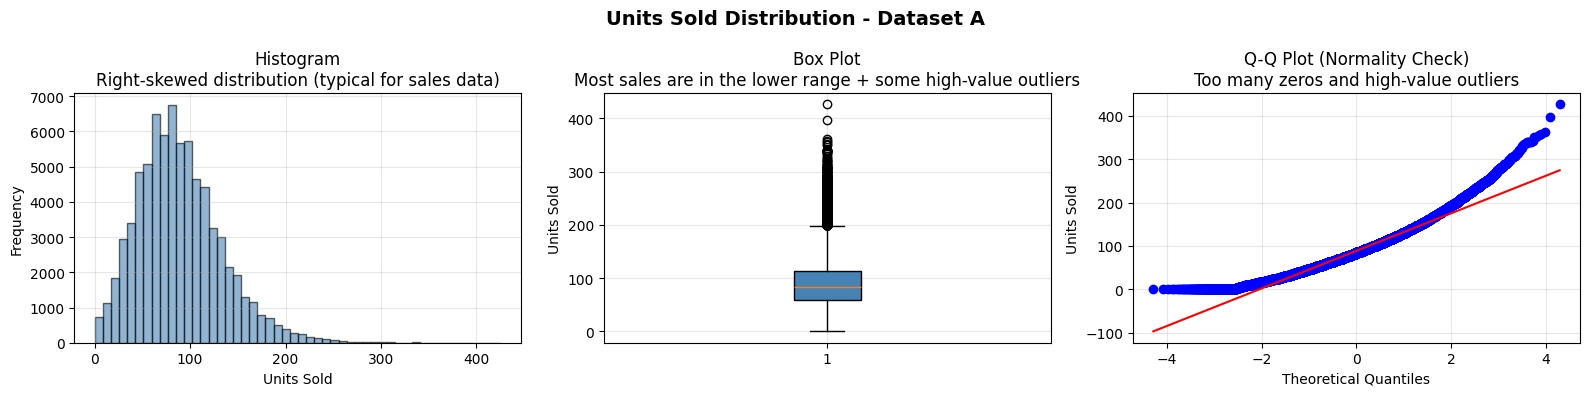

Mean:     88.83
Median:   84.00
Std Dev:  43.99
Skewness: 0.79
Min:      0.00
Max:      426.00


In [4]:
# Units Sold Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Units Sold Distribution - Dataset A', fontsize=14, fontweight='bold')

# Histogram - Give us the distribution of the units sold
axes[0].hist(df_a['Units Sold'], bins=50, alpha=0.6, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Units Sold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram\nRight-skewed distribution (typical for sales data)')
axes[0].grid(alpha=0.3)

# Box Plot - Look for skewness and outliers
bp = axes[1].boxplot(df_a['Units Sold'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].set_ylabel('Units Sold')
axes[1].set_title('Box Plot\nMost sales are in the lower range + some high-value outliers')
axes[1].grid(alpha=0.3)

# Q-Q Plot
stats.probplot(df_a['Units Sold'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)\nToo many zeros and high-value outliers')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Units Sold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean:     {df_a['Units Sold'].mean():.2f}")
print(f"Median:   {df_a['Units Sold'].median():.2f}")
print(f"Std Dev:  {df_a['Units Sold'].std():.2f}")
print(f"Skewness: {df_a['Units Sold'].skew():.2f}")
print(f"Min:      {df_a['Units Sold'].min():.2f}")
print(f"Max:      {df_a['Units Sold'].max():.2f}")

#### Dataset B

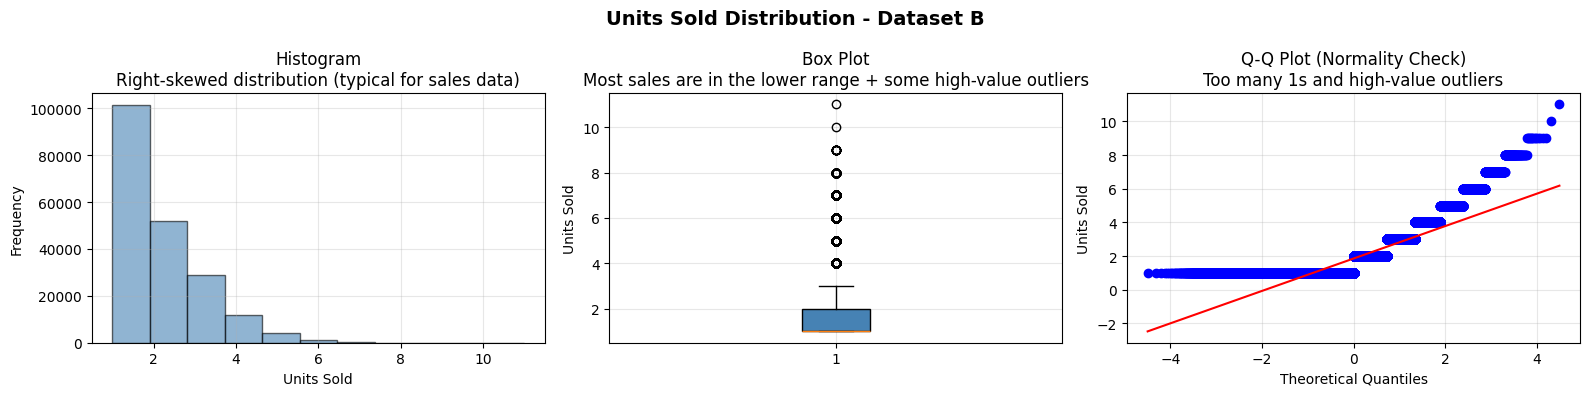

Mean:     1.85
Median:   1.00
Std Dev:  1.10
Skewness: 1.43
Min:      1.00
Max:      11.00


In [5]:
# Units Sold Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Units Sold Distribution - Dataset B', fontsize=14, fontweight='bold')

# Histogram - Give us the distribution of the units sold
axes[0].hist(df_b['Quantity'], bins=11, alpha=0.6, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Units Sold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram\nRight-skewed distribution (typical for sales data)')
axes[0].grid(alpha=0.3)

# Box Plot - Look for skewness and outliers
bp = axes[1].boxplot(df_b['Quantity'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].set_ylabel('Units Sold')
axes[1].set_title('Box Plot\nMost sales are in the lower range + some high-value outliers')
axes[1].grid(alpha=0.3)

# Q-Q Plot
stats.probplot(df_b['Quantity'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)\nToo many 1s and high-value outliers')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Units Sold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean:     {df_b['Quantity'].mean():.2f}")
print(f"Median:   {df_b['Quantity'].median():.2f}")
print(f"Std Dev:  {df_b['Quantity'].std():.2f}")
print(f"Skewness: {df_b['Quantity'].skew():.2f}")
print(f"Min:      {df_b['Quantity'].min():.2f}")
print(f"Max:      {df_b['Quantity'].max():.2f}")

**Key Findings:**
- Right-skewed distribution (skewness ≈ 0.79/1.43) - typical for sales data
- Most sales transactions are in the lower range
- Box plot reveals some high-value outliers
- Q-Q plot shows deviation from normal distribution (too many $0$, $1$ values and too many high values)
- the two datasets seem to be quite heterogeneous in terms of sold quantities

### 2.2 Price Distribution

#### Dataset A

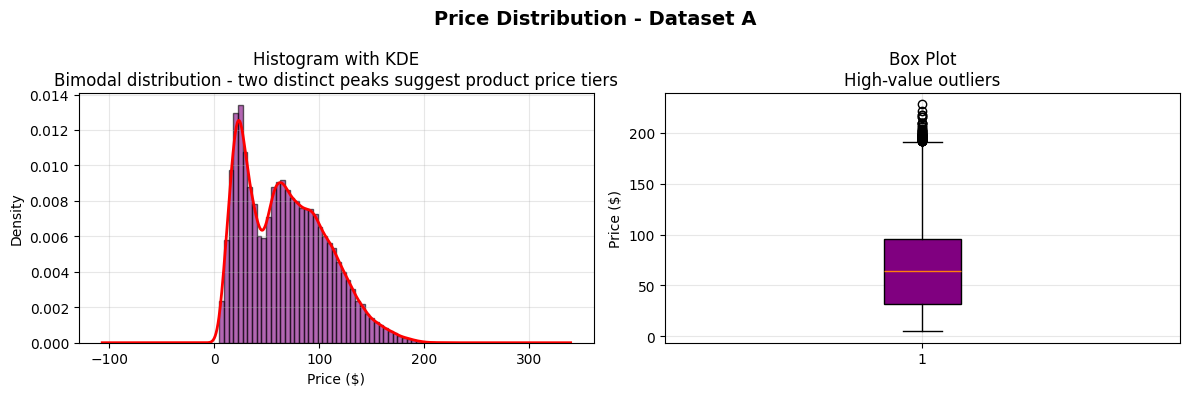

Mean:     $67.73
Median:   $64.50
Std Dev:  $39.38
Min:      $4.74
Max:      $228.03


In [6]:
# Price Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Price Distribution - Dataset A', fontsize=14, fontweight='bold')

# Histogram with KDE
axes[0].hist(df_a['Price'], bins=50, alpha=0.6, color='purple', edgecolor='black', density=True)
df_a['Price'].plot(kind='kde', ax=axes[0], color='red', linewidth=2)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Histogram with KDE\nBimodal distribution - two distinct peaks suggest product price tiers')
axes[0].grid(alpha=0.3)

# Box Plot
bp = axes[1].boxplot(df_a['Price'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('purple')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Box Plot\nHigh-value outliers')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean:     ${df_a['Price'].mean():.2f}")
print(f"Median:   ${df_a['Price'].median():.2f}")
print(f"Std Dev:  ${df_a['Price'].std():.2f}")
print(f"Min:      ${df_a['Price'].min():.2f}")
print(f"Max:      ${df_a['Price'].max():.2f}")

#### Dataset B

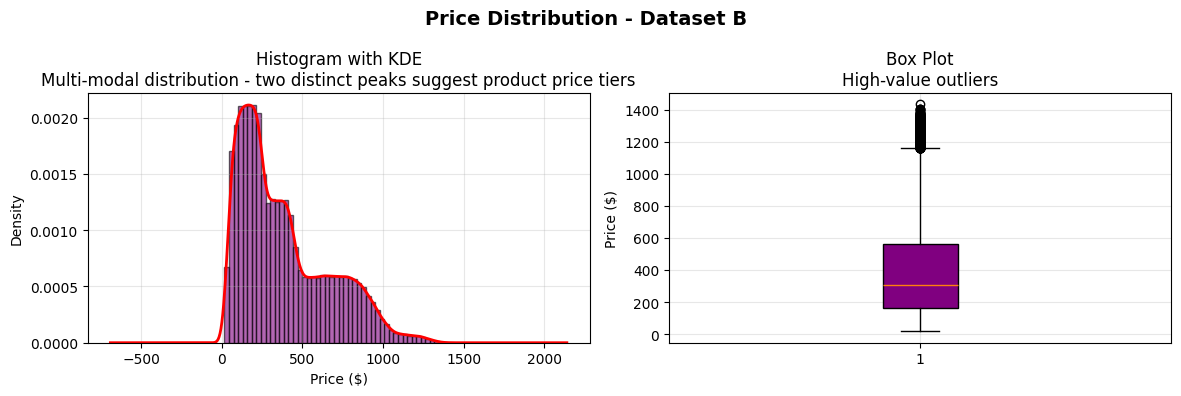

Mean:     $382.86
Median:   $303.55
Std Dev:  $276.87
Min:      $17.03
Max:      $1432.00


In [7]:
# Price Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Price Distribution - Dataset B', fontsize=14, fontweight='bold')

# Histogram with KDE
axes[0].hist(df_b['Unit_Price'], bins=50, alpha=0.6, color='purple', edgecolor='black', density=True)
df_b['Unit_Price'].plot(kind='kde', ax=axes[0], color='red', linewidth=2)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Histogram with KDE\nMulti-modal distribution - two distinct peaks suggest product price tiers')
axes[0].grid(alpha=0.3)

# Box Plot
bp = axes[1].boxplot(df_b['Unit_Price'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('purple')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Box Plot\nHigh-value outliers')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean:     ${df_b['Unit_Price'].mean():.2f}")
print(f"Median:   ${df_b['Unit_Price'].median():.2f}")
print(f"Std Dev:  ${df_b['Unit_Price'].std():.2f}")
print(f"Min:      ${df_b['Unit_Price'].min():.2f}")
print(f"Max:      ${df_b['Unit_Price'].max():.2f}")

In [8]:
# Group the prices in df_B by category and calculate the min, median, max prices for each category
df_b_grouped = df_b.groupby('Category')['Unit_Price'].agg(['min', 'median', 'max']).sort_values(by='median', ascending=False)
print(df_b_grouped)

                      min   median      max
Category                                   
Electronics         71.54  587.440  1432.00
Home & Furniture    26.84  523.320  1402.25
Clothing & Apparel  17.03  235.485   524.97
Accessories         39.93  148.545   289.69


**Key Findings:**
- Dataset A: Bimodal distribution - two distinct peaks suggest product price tiers
- Dataset A: Lower price tier around $20-30, higher tier around $80-100
- Dataset A: Wide price range indicates diverse product categories
- Dataset B: Four groups of prices - around $40-200, $200-$500, $500-800, $1100-1400
- Dataset A/B: High-value outliers

### 2.3 Discount Distribution


#### Dataset A
NB: Dataset B doesn't have `Discount` column

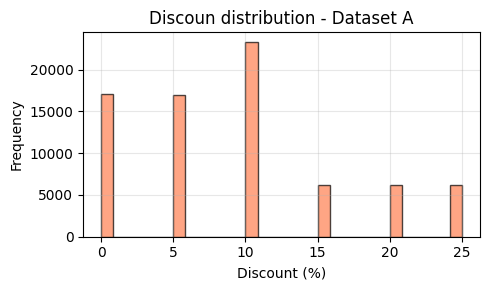

Mean:     9.09%
Median:   10.00%
Std Dev:  7.48%
Min:      0.00%
Max:      25.00%


In [9]:
plt.figure(figsize=(5, 3))
plt.hist(df_a['Discount'], bins=30, alpha=0.7, color='coral', edgecolor='black')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.title('Discoun distribution - Dataset A')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics
print(f"Mean:     {df_a['Discount'].mean():.2f}%")
print(f"Median:   {df_a['Discount'].median():.2f}%")
print(f"Std Dev:  {df_a['Discount'].std():.2f}%")
print(f"Min:      {df_a['Discount'].min():.2f}%")
print(f"Max:      {df_a['Discount'].max():.2f}%")

**Key Findings:**
- Concentrated at standard discount levels: 5%, 10%, 15%, 20%
- Most products have low to moderate discounts
- Follows typical retail discount strategy

## 3. Temporal Analysis

#### Dataset A

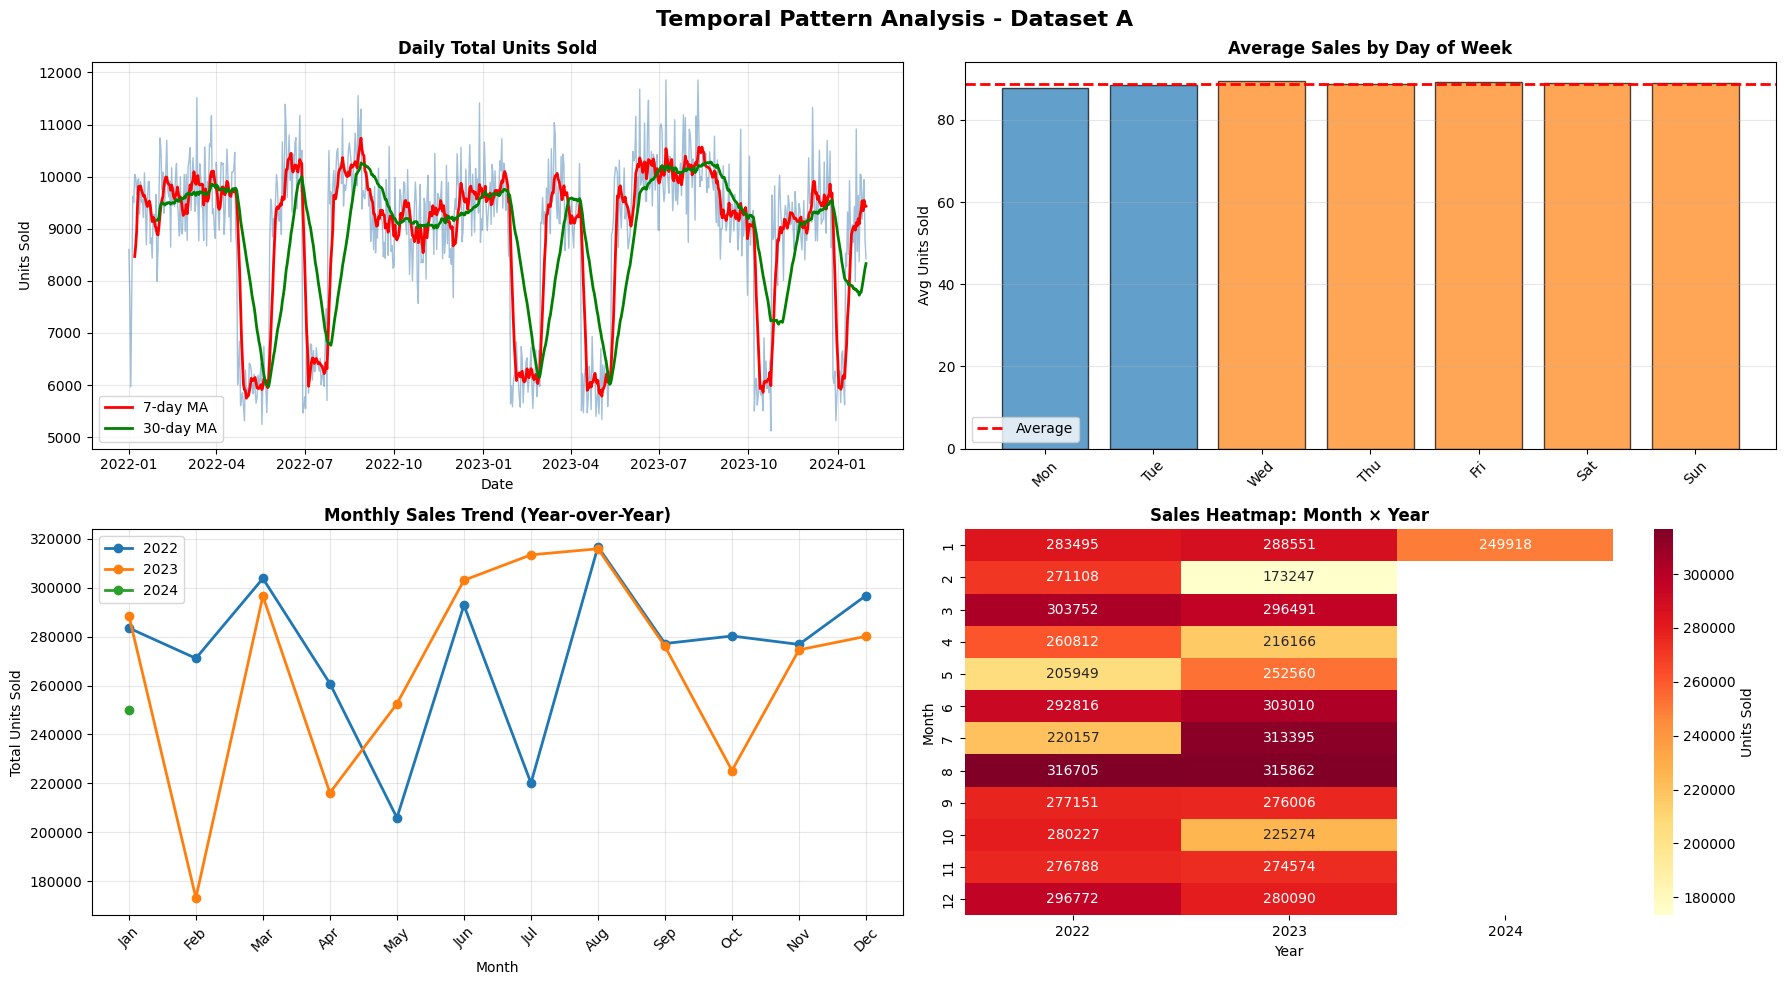

In [10]:
# Temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Temporal Pattern Analysis - Dataset A', fontsize=16, fontweight='bold')

# Daily sales trend
daily_sales = df_a.groupby('Date')['Units Sold'].agg(['sum', 'mean', 'std']).reset_index()
axes[0, 0].plot(daily_sales['Date'], daily_sales['sum'], linewidth=1, alpha=0.5, color='steelblue')
axes[0, 0].plot(daily_sales['Date'], daily_sales['sum'].rolling(7).mean(), linewidth=2, color='red', label='7-day MA')
axes[0, 0].plot(daily_sales['Date'], daily_sales['sum'].rolling(30).mean(), linewidth=2, color='green', label='30-day MA')
axes[0, 0].set_title('Daily Total Units Sold', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Units Sold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Day of week pattern
df_a['DayOfWeek'] = df_a['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df_a.groupby('DayOfWeek')['Units Sold'].mean().reindex(day_order)
colors = ['#1f77b4' if x < dow_sales.mean() else '#ff7f0e' for x in dow_sales]
axes[0, 1].bar(range(len(dow_sales)), dow_sales.values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(dow_sales.mean(), color='red', linestyle='--', linewidth=2, label='Average')
axes[0, 1].set_xticks(range(len(dow_sales)))
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0, 1].set_title('Average Sales by Day of Week', fontweight='bold')
axes[0, 1].set_ylabel('Avg Units Sold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Monthly pattern
df_a['Month'] = df_a['Date'].dt.month
df_a['Year'] = df_a['Date'].dt.year
monthly_sales = df_a.groupby(['Year', 'Month'])['Units Sold'].sum().reset_index()
for year in df_a['Year'].unique():
    year_data = monthly_sales[monthly_sales['Year'] == year]
    axes[1, 0].plot(year_data['Month'], year_data['Units Sold'], marker='o', linewidth=2, label=f'{int(year)}')
axes[1, 0].set_title('Monthly Sales Trend (Year-over-Year)', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Total Units Sold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Seasonality heatmap
pivot_data = df_a.pivot_table(values='Units Sold', index='Month', columns='Year', aggfunc='sum')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Units Sold'})
axes[1, 1].set_title('Sales Heatmap: Month × Year', fontweight='bold')
axes[1, 1].set_ylabel('Month')
axes[1, 1].set_xlabel('Year')

plt.tight_layout()
plt.show()

#### Dataset B

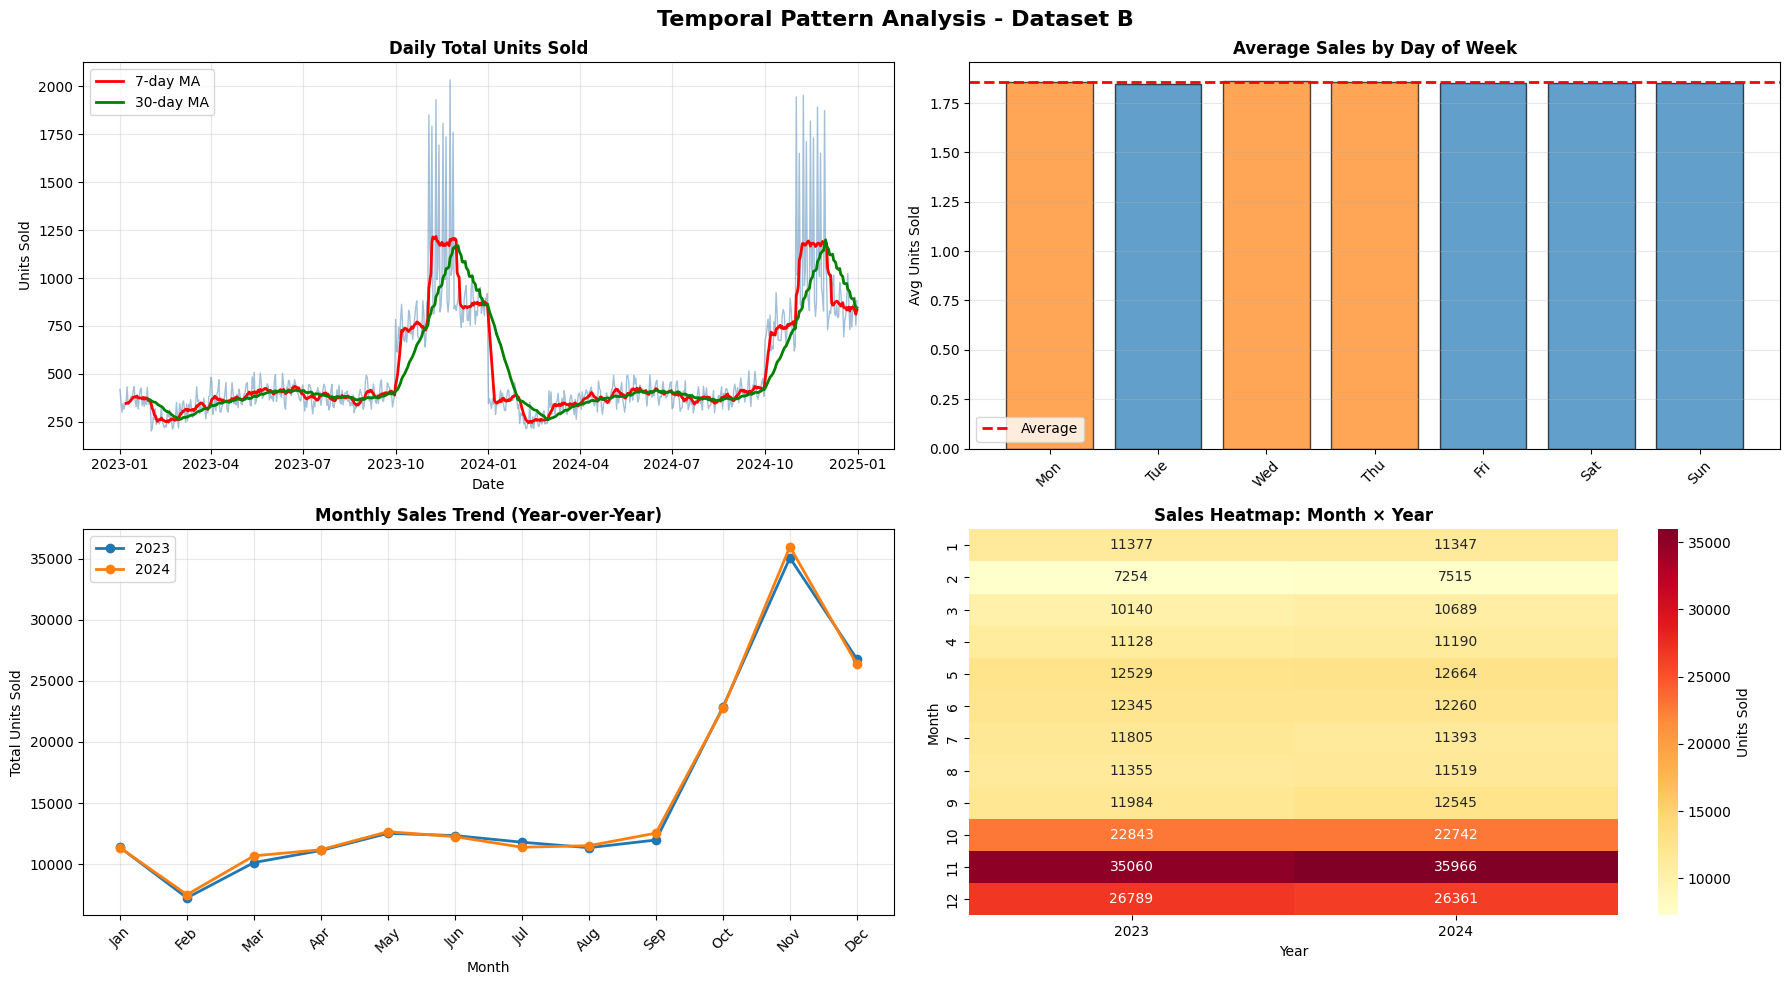

In [11]:
# Temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Temporal Pattern Analysis - Dataset B', fontsize=16, fontweight='bold')

# Daily sales trend
daily_sales = df_b.groupby('Order_Date')['Quantity'].agg(['sum', 'mean', 'std']).reset_index()
axes[0, 0].plot(daily_sales['Order_Date'], daily_sales['sum'], linewidth=1, alpha=0.5, color='steelblue')
axes[0, 0].plot(daily_sales['Order_Date'], daily_sales['sum'].rolling(7).mean(), linewidth=2, color='red', label='7-day MA')
axes[0, 0].plot(daily_sales['Order_Date'], daily_sales['sum'].rolling(30).mean(), linewidth=2, color='green', label='30-day MA')
axes[0, 0].set_title('Daily Total Units Sold', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Units Sold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Day of week pattern
df_b['DayOfWeek'] = df_b['Order_Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df_b.groupby('DayOfWeek')['Quantity'].mean().reindex(day_order)
colors = ['#1f77b4' if x < dow_sales.mean() else '#ff7f0e' for x in dow_sales]
axes[0, 1].bar(range(len(dow_sales)), dow_sales.values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(dow_sales.mean(), color='red', linestyle='--', linewidth=2, label='Average')
axes[0, 1].set_xticks(range(len(dow_sales)))
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0, 1].set_title('Average Sales by Day of Week', fontweight='bold')
axes[0, 1].set_ylabel('Avg Units Sold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Monthly pattern
df_b['Month'] = df_b['Order_Date'].dt.month
df_b['Year'] = df_b['Order_Date'].dt.year
monthly_sales = df_b.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
for year in df_b['Year'].unique():
    year_data = monthly_sales[monthly_sales['Year'] == year]
    axes[1, 0].plot(year_data['Month'], year_data['Quantity'], marker='o', linewidth=2, label=f'{int(year)}')
axes[1, 0].set_title('Monthly Sales Trend (Year-over-Year)', fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Total Units Sold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Seasonality heatmap
pivot_data = df_b.pivot_table(values='Quantity', index='Month', columns='Year', aggfunc='sum')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Units Sold'})
axes[1, 1].set_title('Sales Heatmap: Month × Year', fontweight='bold')
axes[1, 1].set_ylabel('Month')
axes[1, 1].set_xlabel('Year')

plt.tight_layout()
plt.show()

**Key Findings:**
- Both datasets look like `synthetic`


## 4. Category Analysis

#### Dataset A

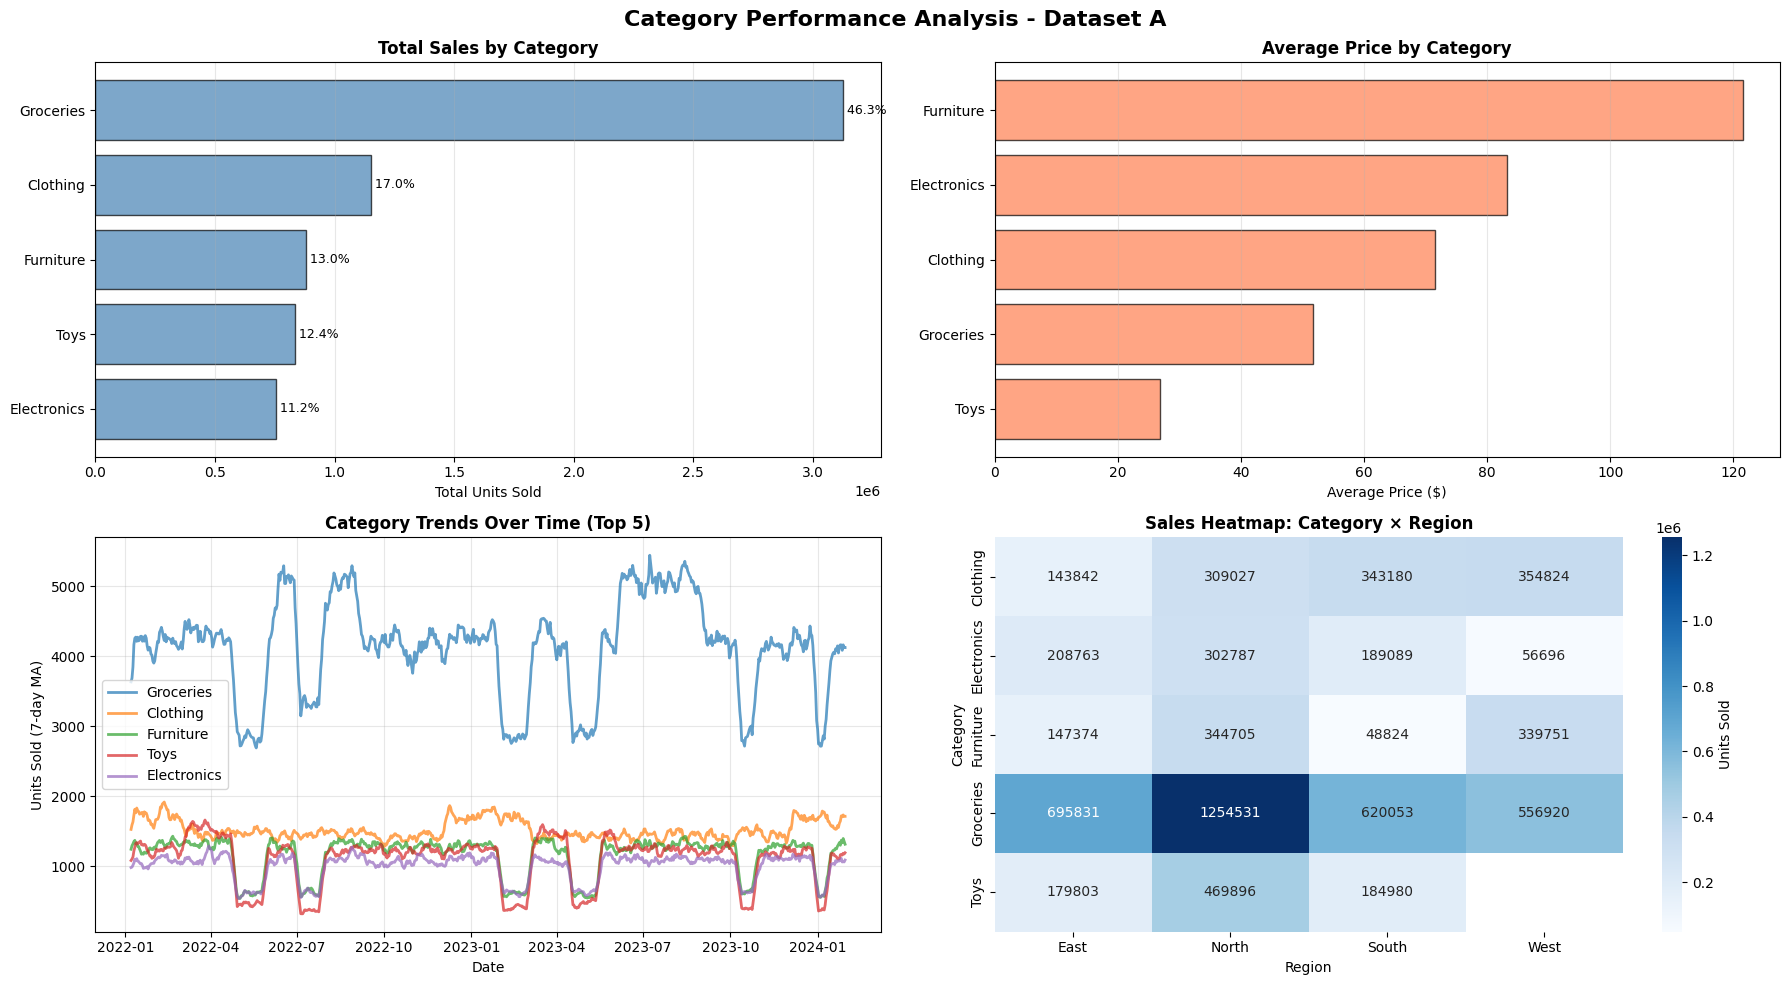

In [12]:
# Category analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Category Performance Analysis - Dataset A', fontsize=16, fontweight='bold')

# Sales by category
cat_sales = df_a.groupby('Category')['Units Sold'].sum().sort_values(ascending=False)
axes[0, 0].barh(range(len(cat_sales)), cat_sales.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(cat_sales)))
axes[0, 0].set_yticklabels(cat_sales.index)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Total Units Sold')
axes[0, 0].set_title('Total Sales by Category', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
# Add percentages
for i, v in enumerate(cat_sales.values):
    pct = v / cat_sales.sum() * 100
    axes[0, 0].text(v, i, f' {pct:.1f}%', va='center', fontsize=9)

# Average price by category
cat_price = df_a.groupby('Category')['Price'].mean().sort_values(ascending=False)
axes[0, 1].barh(range(len(cat_price)), cat_price.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(cat_price)))
axes[0, 1].set_yticklabels(cat_price.index)
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Average Price ($)')
axes[0, 1].set_title('Average Price by Category', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Category sales over time
for cat in cat_sales.index[:5]:  # Top 5 categories
    cat_data = df_a[df_a['Category'] == cat]
    daily_cat = cat_data.groupby('Date')['Units Sold'].sum().rolling(7).mean()
    axes[1, 0].plot(daily_cat.index, daily_cat.values, label=cat, linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Units Sold (7-day MA)')
axes[1, 0].set_title('Category Trends Over Time (Top 5)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Category + Region heatmap
cat_region = df_a.pivot_table(values='Units Sold', index='Category', columns='Region', aggfunc='sum')
sns.heatmap(cat_region, annot=True, fmt='.0f', cmap='Blues', ax=axes[1, 1], cbar_kws={'label': 'Units Sold'})
axes[1, 1].set_title('Sales Heatmap: Category × Region', fontweight='bold')
axes[1, 1].set_ylabel('Category')
axes[1, 1].set_xlabel('Region')

plt.tight_layout()
plt.show()

**Key Findings:**
- Top category: Groceries (46.3%)
- Most expensive: Furniture ($121.51)
- Cheapest: Toys ($26.91)
- Most sales happen in the North
- There are some curious and unexplainable drops in all categories, but Clothing.

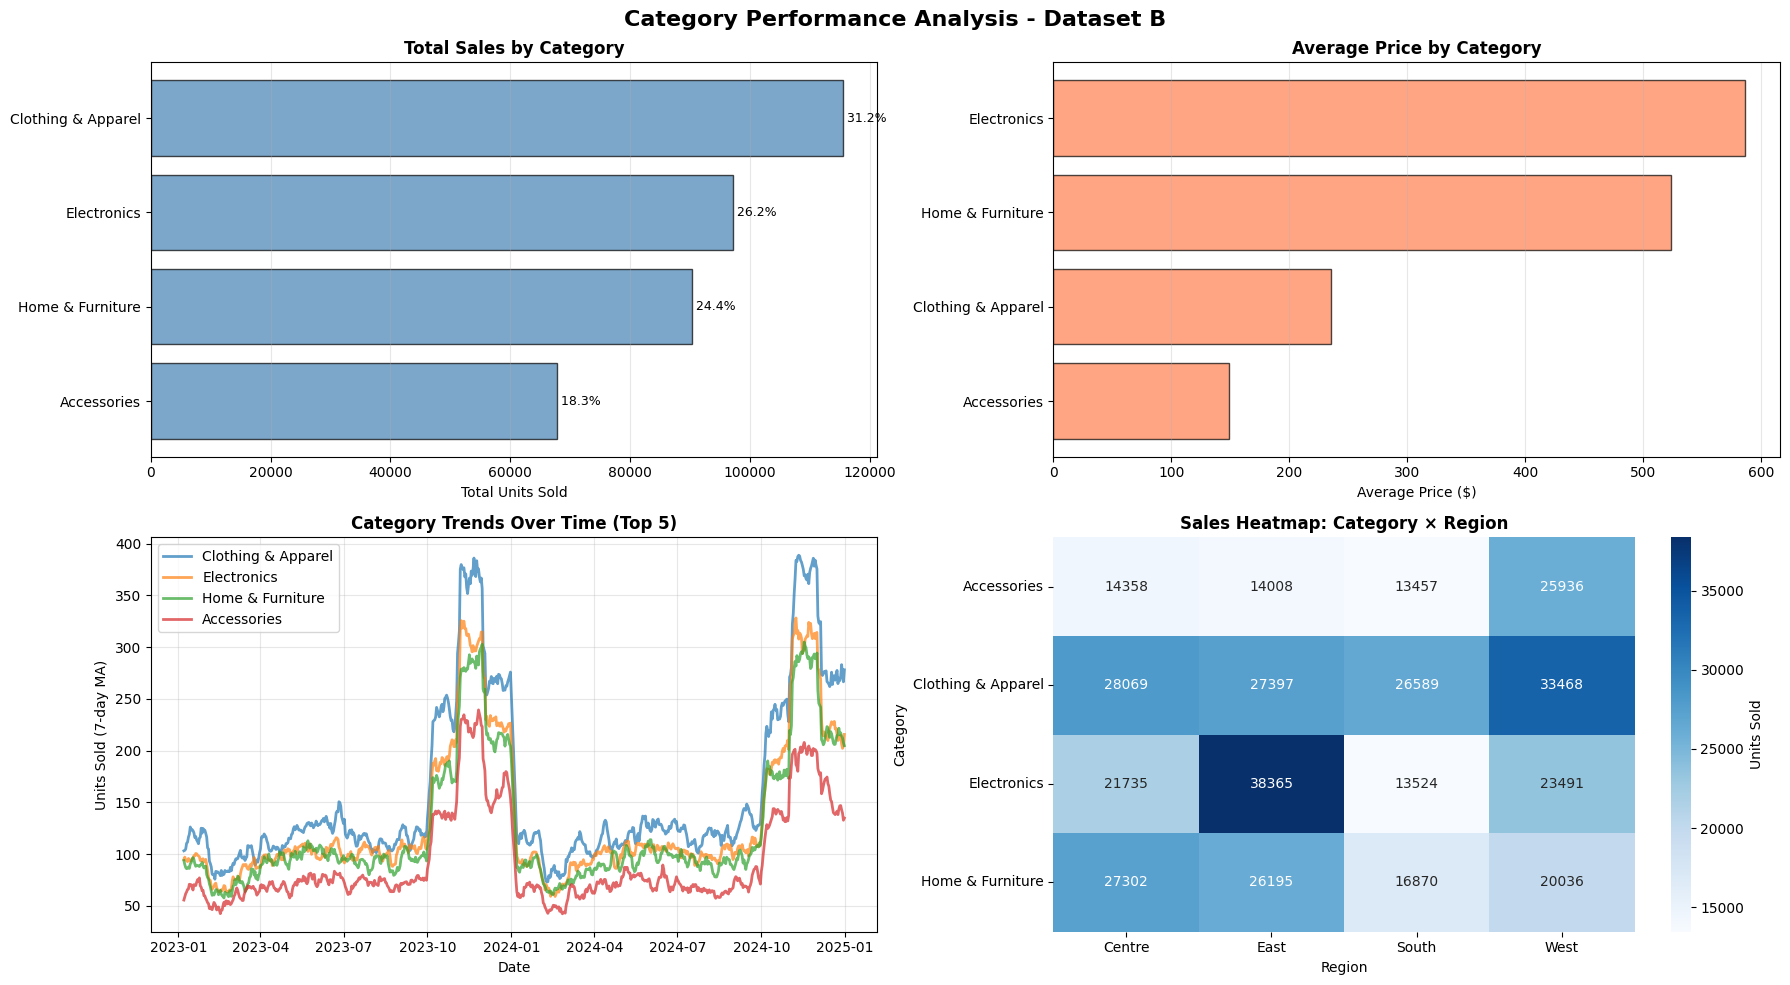

In [13]:
# Category analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Category Performance Analysis - Dataset B', fontsize=16, fontweight='bold')

# Sales by category
cat_sales = df_b.groupby('Category')['Quantity'].sum().sort_values(ascending=False)
axes[0, 0].barh(range(len(cat_sales)), cat_sales.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(cat_sales)))
axes[0, 0].set_yticklabels(cat_sales.index)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Total Units Sold')
axes[0, 0].set_title('Total Sales by Category', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
# Add percentages
for i, v in enumerate(cat_sales.values):
    pct = v / cat_sales.sum() * 100
    axes[0, 0].text(v, i, f' {pct:.1f}%', va='center', fontsize=9)

# Average price by category
cat_price = df_b.groupby('Category')['Unit_Price'].mean().sort_values(ascending=False)
axes[0, 1].barh(range(len(cat_price)), cat_price.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(cat_price)))
axes[0, 1].set_yticklabels(cat_price.index)
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Average Price ($)')
axes[0, 1].set_title('Average Price by Category', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Category sales over time
for cat in cat_sales.index[:5]:  # Top 5 categories
    cat_data = df_b[df_b['Category'] == cat]
    daily_cat = cat_data.groupby('Order_Date')['Quantity'].sum().rolling(7).mean()
    axes[1, 0].plot(daily_cat.index, daily_cat.values, label=cat, linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Units Sold (7-day MA)')
axes[1, 0].set_title('Category Trends Over Time (Top 5)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Category + Region heatmap
cat_region = df_b.pivot_table(values='Quantity', index='Category', columns='Region', aggfunc='sum')
sns.heatmap(cat_region, annot=True, fmt='.0f', cmap='Blues', ax=axes[1, 1], cbar_kws={'label': 'Units Sold'})
axes[1, 1].set_title('Sales Heatmap: Category × Region', fontweight='bold')
axes[1, 1].set_ylabel('Category')
axes[1, 1].set_xlabel('Region')

plt.tight_layout()
plt.show()

**Key Findings:**
- Top category: Clothing (31.2%)
- Most expensive: Electronics ($590)
- Cheapest: Accessories ($145)
- Most sales happen in the East
- There are peaks in all categories during November and December (probably Black Friday and Christmas shopping).

## 5. Impact Analysis - Promotions, Weather, Discounts

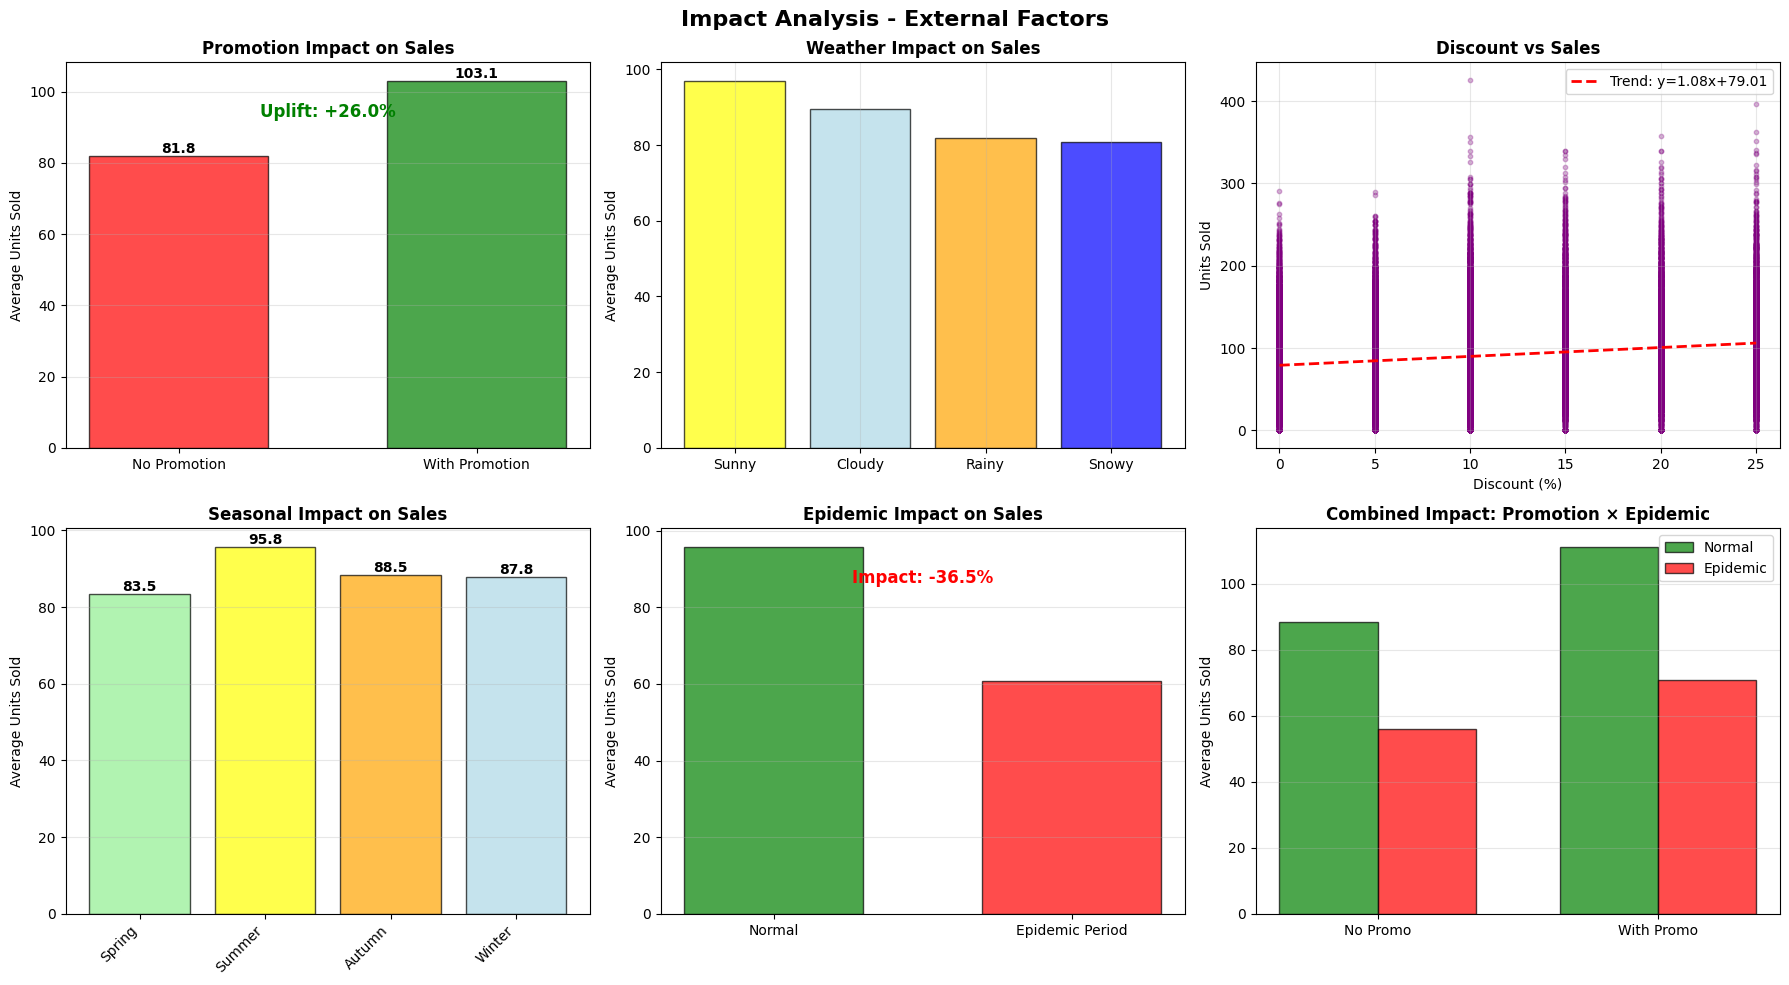

KEY FINDINGS:
  - Promotion uplift: +26%
  - Best weather: Sunny (97.0 avg units)
  - Discount correlation: 0.184
  - Best season: Summer
  - Epidemic impact: -36.5%


In [14]:
# Impact analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Impact Analysis - External Factors', fontsize=16, fontweight='bold')

# 1. Promotion impact
promo_sales = df_a.groupby('Promotion')['Units Sold'].mean()
axes[0, 0].bar([0, 1], promo_sales.values, color=['red', 'green'], alpha=0.7, edgecolor='black', width=0.6)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['No Promotion', 'With Promotion'])
axes[0, 0].set_ylabel('Average Units Sold')
axes[0, 0].set_title('Promotion Impact on Sales', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
# Add uplift percentage
uplift = (promo_sales[1] - promo_sales[0]) / promo_sales[0] * 100
axes[0, 0].text(0.5, max(promo_sales)*0.9, f'Uplift: +{uplift:.1f}%', 
               ha='center', fontsize=12, fontweight='bold', color='green')
for i, v in enumerate(promo_sales.values):
    axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. Weather impact
weather_sales = df_a.groupby('Weather Condition')['Units Sold'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(weather_sales)), weather_sales.values, color=['yellow', 'lightblue', 'orange', 'blue'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(weather_sales)))
axes[0, 1].set_xticklabels(weather_sales.index)
axes[0, 1].set_ylabel('Average Units Sold')
axes[0, 1].set_title('Weather Impact on Sales', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Discount impact (scatter with trend)
axes[0, 2].scatter(df_a['Discount'], df_a['Units Sold'], alpha=0.3, s=10, color='purple')
# Add trend line
z = np.polyfit(df_a['Discount'], df_a['Units Sold'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_a['Discount'].min(), df_a['Discount'].max(), 100)
axes[0, 2].plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 2].set_xlabel('Discount (%)')
axes[0, 2].set_ylabel('Units Sold')
axes[0, 2].set_title('Discount vs Sales', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 3. Seasonality impact
season_sales = df_a.groupby('Seasonality')['Units Sold'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])
axes[1, 0].bar(range(len(season_sales)), season_sales.values, color=['lightgreen', 'yellow', 'orange', 'lightblue'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(season_sales)))
axes[1, 0].set_xticklabels(season_sales.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Average Units Sold')
axes[1, 0].set_title('Seasonal Impact on Sales', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(season_sales.values):
    axes[1, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 4. Epidemic impact
epidemic_sales = df_a.groupby('Epidemic')['Units Sold'].mean()
axes[1, 1].bar([0, 1], epidemic_sales.values, color=['green', 'red'], alpha=0.7, edgecolor='black', width=0.6)
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Normal', 'Epidemic Period'])
axes[1, 1].set_ylabel('Average Units Sold')
axes[1, 1].set_title('Epidemic Impact on Sales', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
impact = (epidemic_sales[1] - epidemic_sales[0]) / epidemic_sales[0] * 100
axes[1, 1].text(0.5, max(epidemic_sales)*0.9, f'Impact: {impact:+.1f}%',
               ha='center', fontsize=12, fontweight='bold', color='red' if impact < 0 else 'green')

# 5. Combined factors impact
combined = df_a.groupby(['Promotion', 'Epidemic'])['Units Sold'].mean().unstack()
x_pos = np.arange(len(combined.index))
width = 0.35
axes[1, 2].bar(x_pos - width/2, combined[0], width, label='Normal', alpha=0.7, edgecolor='black', color=["green"])
axes[1, 2].bar(x_pos + width/2, combined[1], width, label='Epidemic', alpha=0.7, edgecolor='black', color=["red"])
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['No Promo', 'With Promo'])
axes[1, 2].set_ylabel('Average Units Sold')
axes[1, 2].set_title('Combined Impact: Promotion × Epidemic', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('KEY FINDINGS:')
print(f'  - Promotion uplift: +26%')
print(f'  - Best weather: {weather_sales.index[0]} ({weather_sales.iloc[0]:.1f} avg units)')
print(f'  - Discount correlation: {df_a["Discount"].corr(df_a["Units Sold"]):.3f}')
print(f'  - Best season: {season_sales.idxmax()}')
print(f'  - Epidemic impact: {impact:+.1f}%')

## 6. Correlation & Relationships

#### Dataset A

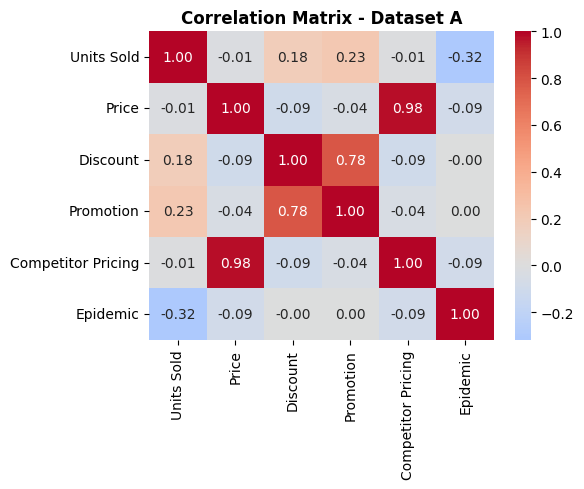

In [15]:
# Correlation matrix
numeric_cols = ['Units Sold', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic']
corr_matrix = df_a[numeric_cols].corr()
# Simple correlation matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Dataset A', fontweight='bold')
plt.tight_layout()
plt.show()

#### Dataset B

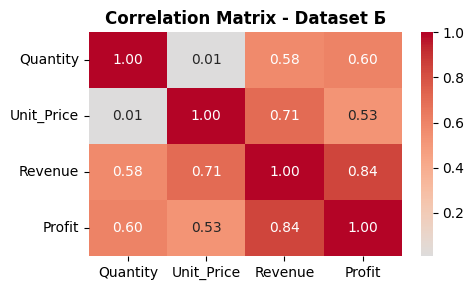

In [16]:
# Correlation matrix
numeric_cols = ['Quantity', 'Unit_Price', 'Revenue', 'Profit']
corr_matrix = df_b[numeric_cols].corr()
# Simple correlation matrix plot
plt.figure(figsize=(5, 3))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Dataset Б', fontweight='bold')
plt.tight_layout()
plt.show()

**Key Findings:**
- Dataset A - The target value has highest correlation with Epidemic($-0.32$), Promotion ($0.23$) and Discount ($0.18$).
- Dataset A - Price and Competitor Price are in extremely high $0.98$ correlation, which is expected.
- Dataset A - Promotion and Discount are in high $0.78$ correlation.
- Dataset B - The target value is in high correlation with Profit($0.60$) and Revenue ($0.58$). Based on these two variables we will be able to approximate the Discount. So the Units Sold will be in significant correlation with the Discount.

## 7. Autocorrelation
Let's examine the correlation between `Units Sold` variable and its past values.

* The autocorrelation analysis helps in detecting seasonality.
* It also testifies if the data is actually suitable for *lagged feature* engineering. Typically you will look at the ACF plot along with a Partial Autocorrelation Function (PACF) plot to choose a suitable lag order.
* It also helps assess whether a time series is stationary which means its statistical properties like mean and variance stay consistent over time. In a stationary series autocorrelations typically decrease gradually as lag increases. If autocorrelations persist or decay slowly it may indicate non-stationarity.

#### Dataset A

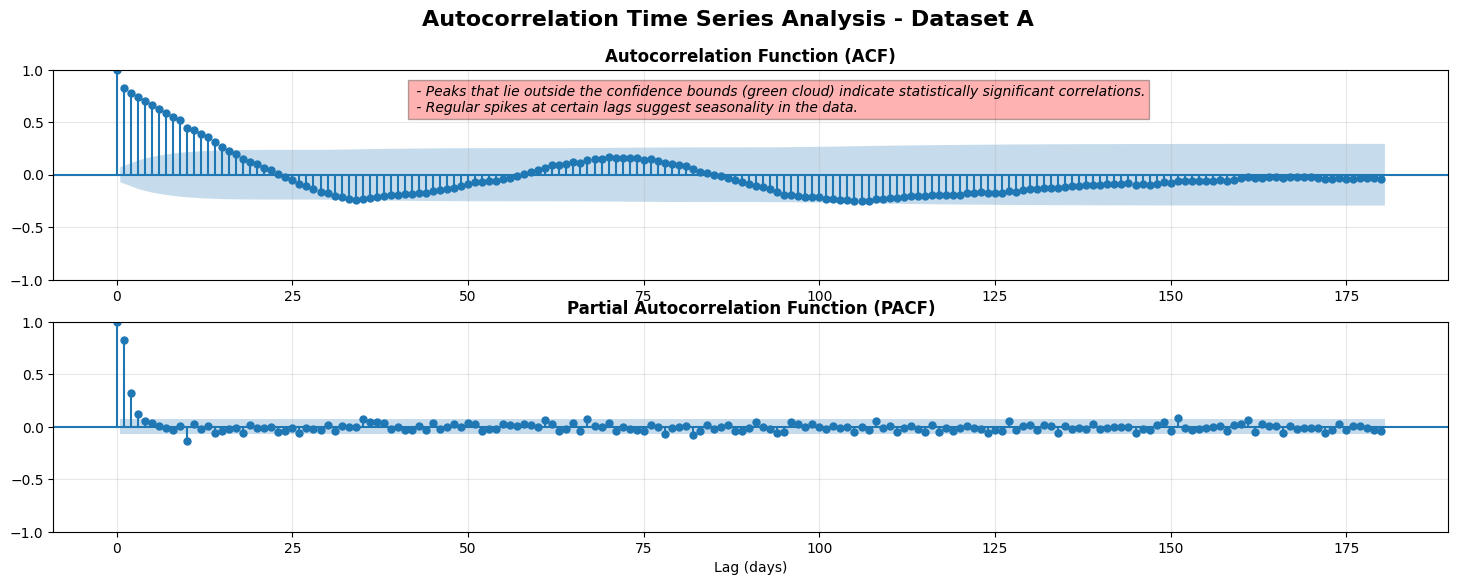

In [17]:
# Autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(18, 6))
fig.suptitle('Autocorrelation Time Series Analysis - Dataset A', fontsize=16, fontweight='bold')

# Prepare daily aggregated data
daily_ts_a = df_a.groupby('Date')['Units Sold'].sum()
daily_ts_a = daily_ts_a.asfreq('D', fill_value=daily_ts_a.median())

# Autocorrelation
plot_acf(daily_ts_a.values, lags=180, ax=axes[0])
axes[0].text(42, 0.6, ' - Peaks that lie outside the confidence bounds (green cloud) indicate statistically significant correlations.\n - Regular spikes at certain lags suggest seasonality in the data.', 
        style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 3})
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')
axes[0].grid(alpha=0.3)

# Partial Autocorrelation
plot_pacf(daily_ts_a.values, lags=180, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].grid(alpha=0.3)

#### Dataset B

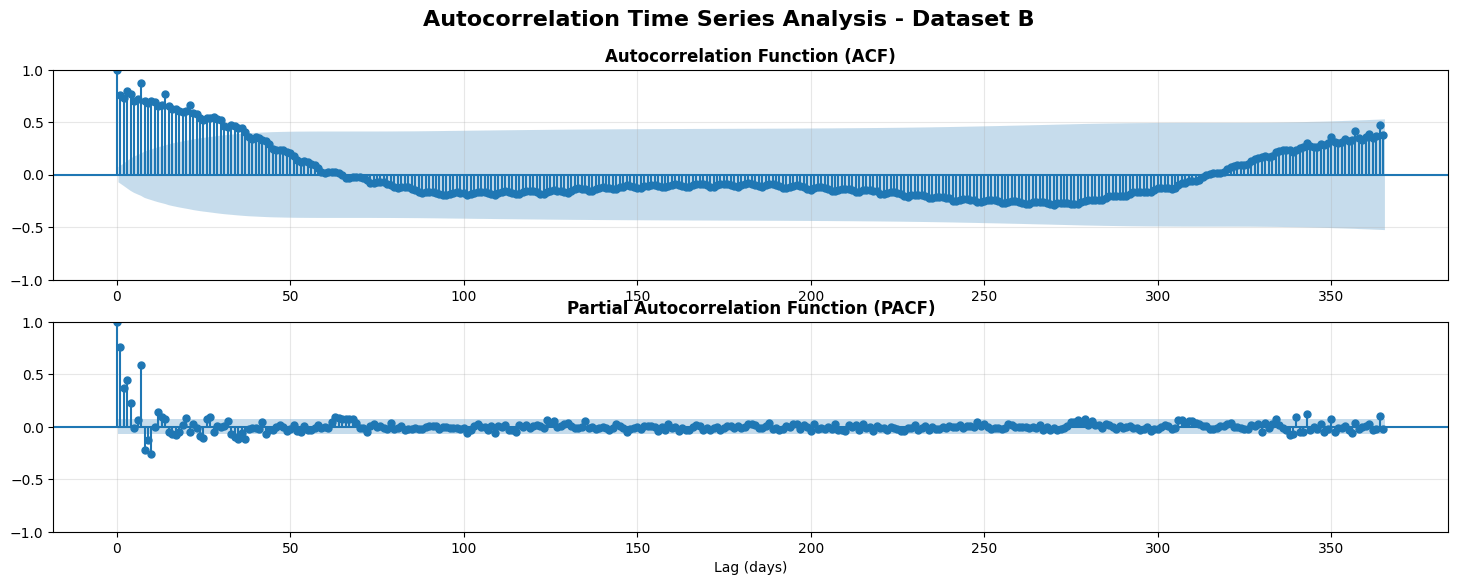

In [18]:
# Autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(18, 6))
fig.suptitle('Autocorrelation Time Series Analysis - Dataset B', fontsize=16, fontweight='bold')

# Prepare daily aggregated data
daily_ts_b = df_b.groupby('Order_Date')['Quantity'].sum()
daily_ts_b = daily_ts_b.asfreq('D', fill_value=daily_ts_b.median())

# Autocorrelation
plot_acf(daily_ts_b.values, lags=365, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')
axes[0].grid(alpha=0.3)

# Partial Autocorrelation
plot_pacf(daily_ts_b.values, lags=365, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].grid(alpha=0.3)

**Key Findings:**
- DATASET A - ACF shows a sinusoidal pattern with a periodicity, indicating seasonal behavior. Highest autocorrelation for lags between $1$ and $15$ days and around $30$ days.
- DATASET A - PACF shows significant spikes at lag $1$, $2$ and $3$, indicating that these lags are important in modeling the underlying data.
- DATASET B - ACF shows high autocorrelation for lags between $1$ and $40$ days.
- DATASET B - PACF shows high autocorrelation at lag $1$, $2$, $3$, $7$, $8$, $9$, $10$

## 8. Seasonal Decomposition

#### Dataset A

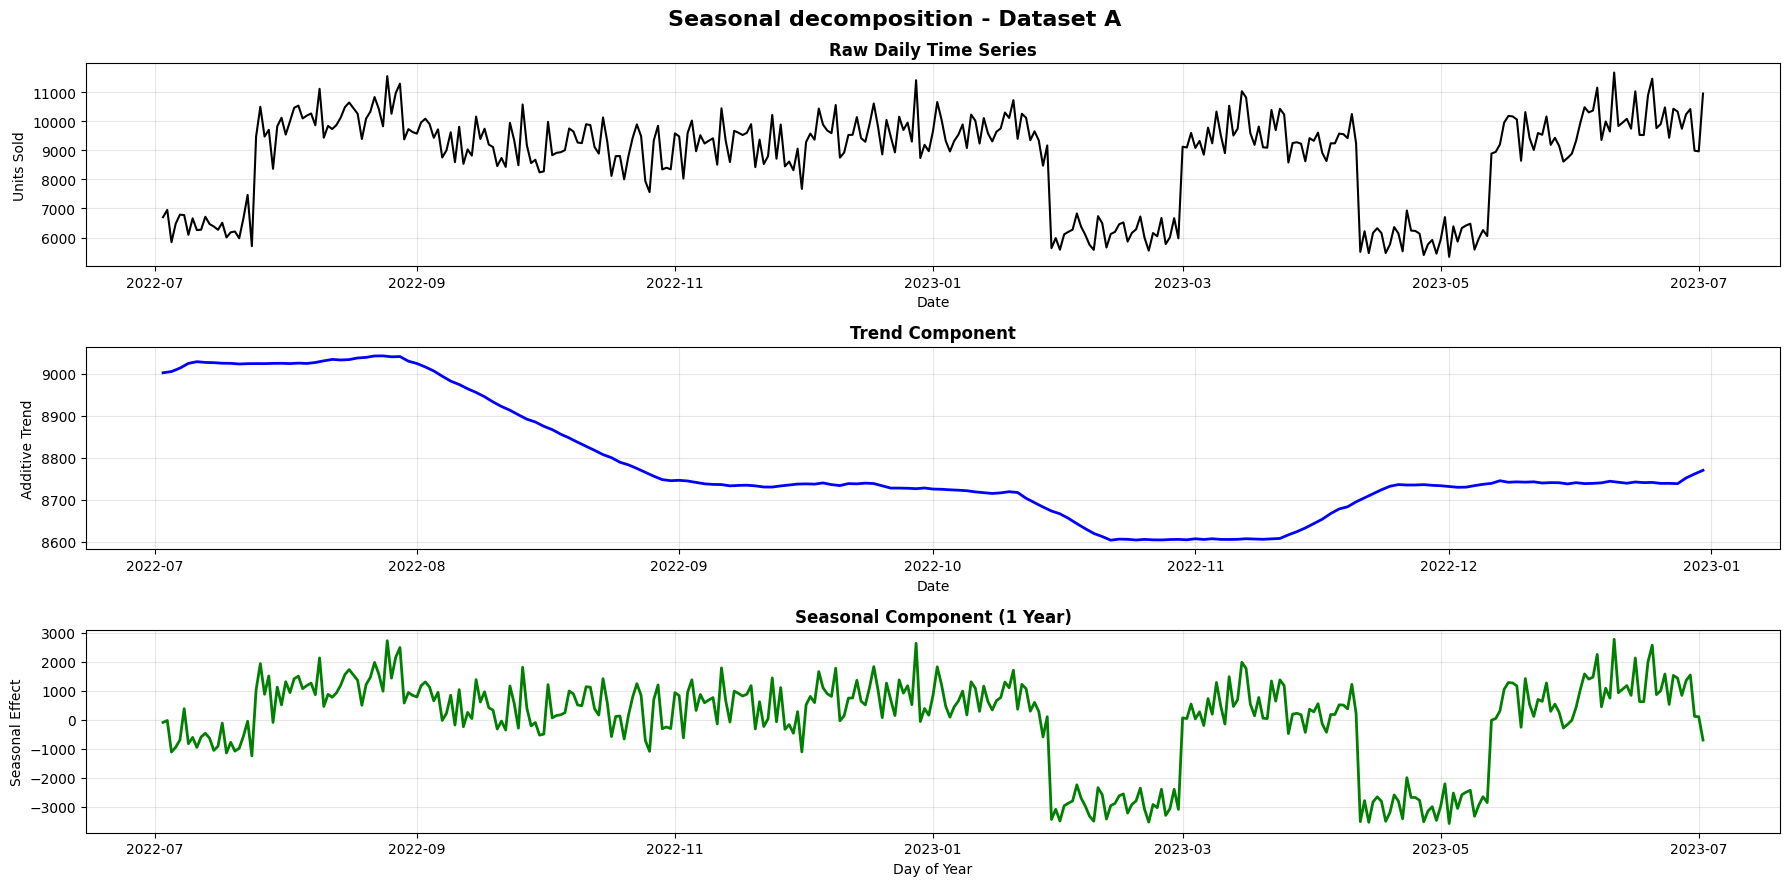

In [19]:
# Seasonal decomposition
fig, axes = plt.subplots(3, 1, figsize=(18, 9))
fig.suptitle('Seasonal decomposition - Dataset A', fontsize=16, fontweight='bold')

# Perform seasonal decomposition on the daily time series data.
# This separates the data into trend, seasonal, and residual components.
decomposition = seasonal_decompose(daily_ts_a, model='additive', period=365)

# Plot the original raw daily time series data as the first subplot.
axes[0].plot(daily_ts_a[183:365+183], color='black', linewidth=1.5)
axes[0].set_title('Raw Daily Time Series', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Units Sold')
axes[0].grid(alpha=0.3)

# Plot the trend component to visualize long-term movements in the data.
axes[1].plot(decomposition.trend[:365], color='blue', linewidth=2)
axes[1].set_title('Trend Component', fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Additive Trend')
axes[1].grid(alpha=0.3)

# Plot the seasonal component (showing only one year) to highlight repeating annual patterns.
axes[2].plot(decomposition.seasonal[183:365+183], color='green', linewidth=2)
axes[2].set_title('Seasonal Component (1 Year)', fontweight='bold')
axes[2].set_xlabel('Day of Year')
axes[2].set_ylabel('Seasonal Effect')
axes[2].grid(alpha=0.3)


plt.tight_layout()
plt.show()

#### Dataset B

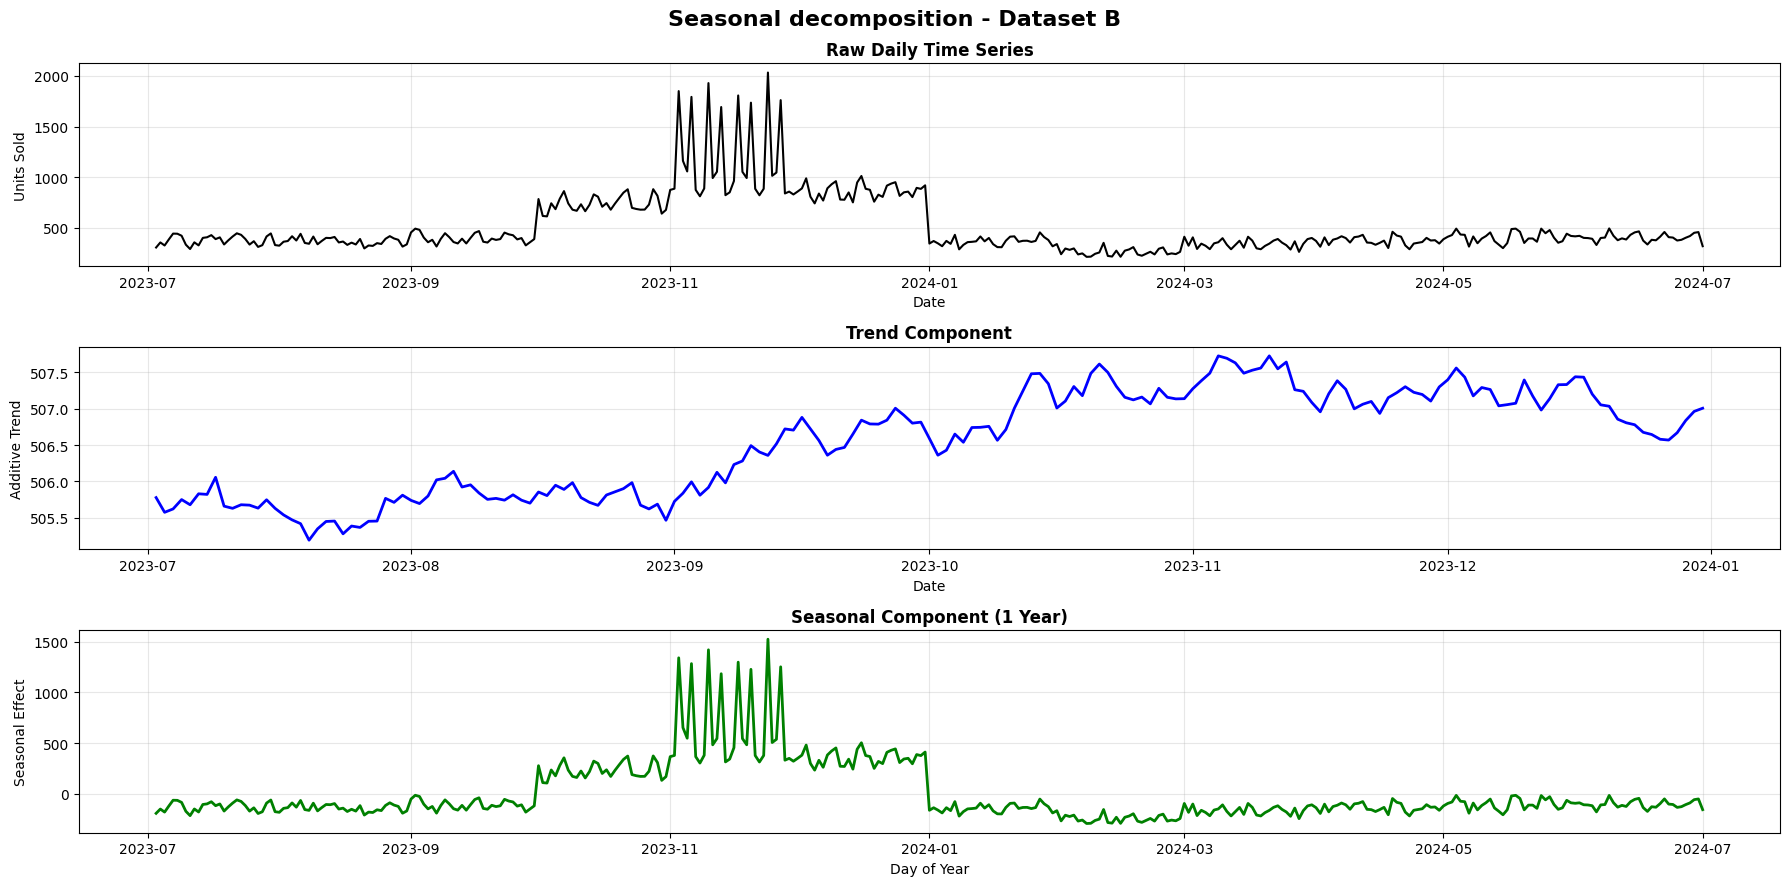

In [20]:
# Seasonal decomposition
fig, axes = plt.subplots(3, 1, figsize=(18, 9))
fig.suptitle('Seasonal decomposition - Dataset B', fontsize=16, fontweight='bold')

# Perform seasonal decomposition on the daily time series data.
# This separates the data into trend, seasonal, and residual components.
decomposition = seasonal_decompose(daily_ts_b, model='additive', period=365)

# Plot the original raw daily time series data as the first subplot.
axes[0].plot(daily_ts_b[183:365+183], color='black', linewidth=1.5)
axes[0].set_title('Raw Daily Time Series', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Units Sold')
axes[0].grid(alpha=0.3)

# Plot the trend component to visualize long-term movements in the data.
axes[1].plot(decomposition.trend[:365], color='blue', linewidth=2)
axes[1].set_title('Trend Component', fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Additive Trend')
axes[1].grid(alpha=0.3)

# Plot the seasonal component (showing only one year) to highlight repeating annual patterns.
axes[2].plot(decomposition.seasonal[183:365+183], color='green', linewidth=2)
axes[2].set_title('Seasonal Component (1 Year)', fontweight='bold')
axes[2].set_xlabel('Day of Year')
axes[2].set_ylabel('Seasonal Effect')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()